**Hyperloglog**

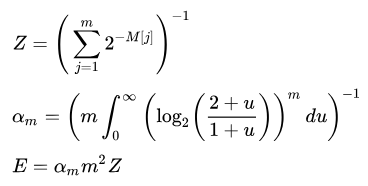
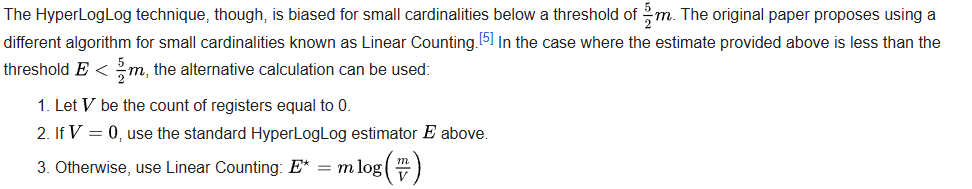

In [150]:
import math
import hashlib

In [151]:
class hyperloglog:
    def __init__(self, r=16):
        self.r = r
        self.m = 2 ** r
        self.registers = [0] * self.m
        self.mod = 2 ** 64
        
        if self.m == 16:
            self.alpha = 0.673
        elif self.m == 32:
            self.alpha = 0.697
        elif self.m == 64:
            self.alpha = 0.709
        else:
            self.alpha = 0.7213 / (1 + 1.079 / self.m)

    def count_zeros(self, w_bits):
        count = 0
        for bit in reversed(w_bits):
            if bit == '0':
                count += 1
            else:
                break
        return count + 1

    def add(self, elem):
        x_int = int(hashlib.sha256(str(elem).encode()).hexdigest(), 16) % self.mod
        bin_h = bin(x_int)[2:].zfill(64)
        
        idx = int(bin_h[:self.r], 2)
        w = bin_h[self.r:]
        count_zeros = self.count_zeros(w)
        
        self.registers[idx] = max(self.registers[idx], count_zeros)

    def calc_size(self):
        
        sum_2_pow = sum(2.0 ** -reg for reg in self.registers)
        Z = 1.0 / sum_2_pow
        E = self.alpha * self.m ** 2 * Z
        
        if E < 2.5 * self.m:
            V = self.registers.count(0)
            if V > 0:
                E = self.m * math.log(self.m / V)
        
        return int(E)

In [152]:

def test_empty_set():
    """Тест 1: Пустое множество"""
    hll = hyperloglog(r=16)
    est = hll.calc_size()
    assert est == 0, est
    print(f"Тест 1: Пустое множество OK, {est}")

def test_unique_elements_count():
    """Тест 2:  проверка подсчета уникальных элементов"""
    hll = hyperloglog(r=16)
    n = 1000
    for i in range(n):
        hll.add(f"elem_{i}")
    est = hll.calc_size()
    error = abs(est - n) / n * 100
    assert error < 1, error
    print(f"Тест 2: {n} уникальных элементов OK, {error}, {est}")


def test_disjoint_sets():
    """Тест 3: Проверка дубликатов"""
    hll = hyperloglog(r=16)
    n = 1000
    for _ in range(n):
        hll.add("same")
    est = hll.calc_size()
    error = abs(est - 1) / 1 * 100
    assert error < 1, error
    print(f"Тест 3: {n} дубликатов OK, {error}, {est}")


def test_big_set():
    """Тест 4: Большое множество"""
    hll = hyperloglog(r=16)
    n = 100000
    for i in range(n):
        hll.add(f"elem_{i}")
    est = hll.calc_size()
    error = abs(est - n) / n * 100
    assert error < 1, error
    print(f"Тест 4: {n} элементов OK, {error}, {est}")


def run_all_tests():
    tests = [test_empty_set, test_unique_elements_count, test_disjoint_sets, test_big_set]
    
    for test in tests:
        try:
            test()
        except Exception as e:
            print(f"{test.__name__} провален: {e}")
            return
    print("ВСЕ ТЕСТЫ ПРОЙДЕНЫ")


if __name__ == "__main__":
    run_all_tests()

Тест 1: Пустое множество OK, 0
Тест 2: 1000 уникальных элементов OK, 0.1, 999
Тест 3: 1000 дубликатов OK, 0.0, 1
Тест 4: 100000 элементов OK, 0.705, 100705
ВСЕ ТЕСТЫ ПРОЙДЕНЫ
